# Lab 4: Basic text preprocessing and topic modeling

The goal of this assignment is to get familiar with textual data analysis.


**Submission: submit via onq.** 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import needed libiraries

In [2]:
! pip install -q nltk
! pip install -q upgrade gensim
! pip install -q pyLDAvis
! pip install -q pandarallel

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
     |████████████████████████████████| 1.7 MB 34.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [3]:
# Import needed libraries. E.g., pandas, sklearn, nltk, etc. 
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import gensim
from gensim import corpora
import pandarallel
from pandarallel import pandarallel


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Task 1
#### The given dataset is a table containing questions about R on StackOverflow site. Your first task is to perform standard text prepossessing steps introduced in lectures for future tasks. You can perform analysis on title or body of the questions.

In [5]:
# TODO code for task 1
data = pd.read_csv("/content/drive/MyDrive/Questions.csv")
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189930 entries, 0 to 189929
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            189930 non-null  int64  
 1   OwnerUserId   188729 non-null  float64
 2   CreationDate  189930 non-null  object 
 3   Score         189930 non-null  int64  
 4   Title         189930 non-null  object 
 5   Body          189930 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.7+ MB


In [6]:
data

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,3,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...
...,...,...,...,...,...,...
189925,46395878,1823293.0,2017-09-24T23:43:50Z,1,GET command in httr not returning anything aft...,<p>I'm trying to access NBA's stats api which ...
189926,46395904,8666903.0,2017-09-24T23:49:42Z,2,R-shiny: Discrete value supplied to continuous...,<p>So I am using mpg dataset to practice my R-...
189927,46395907,8663707.0,2017-09-24T23:50:13Z,2,Confidence interval for quantile regression us...,<p>I am trying to get the five types of bootst...
189928,46395927,8061255.0,2017-09-24T23:52:32Z,1,Time lag analysis on list of imputed datasets,<p>My question and data is similar to the post...


In [7]:
data.drop_duplicates(inplace=True)

In [8]:
! pip install -q pandarallel

In [9]:
data['Title']=data['Title'].apply(str)

In [10]:
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not"}
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
data['Title']=data['Title'].apply(lambda x:expand_contractions(x))

In [11]:
data['Title']

0                 How to access the last value in a vector?
1         Worse sin: side effects or passing massive obj...
2                      Explain the quantile() function in R
3                        How to test for the EOF flag in R?
4         Is there an R package for learning a Dirichlet...
                                ...                        
189925    GET command in httr not returning anything aft...
189926    R-shiny: Discrete value supplied to continuous...
189927    Confidence interval for quantile regression us...
189928        Time lag analysis on list of imputed datasets
189929    How do I conditionally format text in Shiny gi...
Name: Title, Length: 189930, dtype: object

In [12]:
data['Title']=data['Title'].apply(lambda x:x.lower())

In [13]:
data['Title']

0                 how to access the last value in a vector?
1         worse sin: side effects or passing massive obj...
2                      explain the quantile() function in r
3                        how to test for the eof flag in r?
4         is there an r package for learning a dirichlet...
                                ...                        
189925    get command in httr not returning anything aft...
189926    r-shiny: discrete value supplied to continuous...
189927    confidence interval for quantile regression us...
189928        time lag analysis on list of imputed datasets
189929    how do i conditionally format text in shiny gi...
Name: Title, Length: 189930, dtype: object

In [14]:
#remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
data['Title']= data['Title'].apply(lambda x: remove_stopwords(x))

In [15]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
data['Title'] = data['Title'].apply(lambda text: lemmatize_words(text))

In [16]:
data['Title']

0                                 access last value vector?
1           worse sin: side effect passing massive objects?
2                             explain quantile() function r
3                                          test eof flag r?
4             r package learning dirichlet prior count data
                                ...                        
189925           get command httr returning anything minute
189926    r-shiny: discrete value supplied continuous scale
189927    confidence interval quantile regression using ...
189928              time lag analysis list imputed datasets
189929    conditionally format text shiny given lookup h...
Name: Title, Length: 189930, dtype: object

In [17]:
data['Title']= data['Title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
data['Title'] = data['Title'].apply(lambda x: re.sub('W*dw*','',x))
data['Title'] = data['Title'].apply(lambda x: re.sub(' +', ' ', x))

In [18]:
data['Title']

0                                  access last value vector
1              worse sin sie effect passing massive objects
2                               explain quantile function r
3                                           test eof flag r
4               r package learning irichlet prior count ata
                                ...                        
189925            get comman httr returning anything minute
189926        rshiny iscrete value supplie continuous scale
189927    confience interval quantile regression using b...
189928                time lag analysis list impute atasets
189929    conitionally format text shiny given lookup he...
Name: Title, Length: 189930, dtype: object

In [19]:
pandarallel.initialize(progress_bar=True)
data['Title'] = data['Title'].parallel_apply(lambda x:  nltk.word_tokenize(x))
data['Title']

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


0                             [access, last, value, vector]
1         [worse, sin, sie, effect, passing, massive, ob...
2                          [explain, quantile, function, r]
3                                      [test, eof, flag, r]
4         [r, package, learning, irichlet, prior, count,...
                                ...                        
189925     [get, comman, httr, returning, anything, minute]
189926    [rshiny, iscrete, value, supplie, continuous, ...
189927    [confience, interval, quantile, regression, us...
189928         [time, lag, analysis, list, impute, atasets]
189929    [conitionally, format, text, shiny, given, loo...
Name: Title, Length: 189930, dtype: object

In [20]:
new=data['Title']
new

0                             [access, last, value, vector]
1         [worse, sin, sie, effect, passing, massive, ob...
2                          [explain, quantile, function, r]
3                                      [test, eof, flag, r]
4         [r, package, learning, irichlet, prior, count,...
                                ...                        
189925     [get, comman, httr, returning, anything, minute]
189926    [rshiny, iscrete, value, supplie, continuous, ...
189927    [confience, interval, quantile, regression, us...
189928         [time, lag, analysis, list, impute, atasets]
189929    [conitionally, format, text, shiny, given, loo...
Name: Title, Length: 189930, dtype: object

In [21]:
def convert(list):
    return tuple(list)
new=convert(new)

In [22]:
new

(['access', 'last', 'value', 'vector'],
 ['worse', 'sin', 'sie', 'effect', 'passing', 'massive', 'objects'],
 ['explain', 'quantile', 'function', 'r'],
 ['test', 'eof', 'flag', 'r'],
 ['r', 'package', 'learning', 'irichlet', 'prior', 'count', 'ata'],
 ['optimization', 'package', 'r'],
 ['thinking', 'vector', 'r'],
 ['vectorize', 'thinking', 'vector', 'operation', 'r'],
 ['r', 'compile', 'language'],
 ['filtering', 'ata', 'r'],
 ['operating', 'time', 'interval', 'like', '08000815'],
 ['easiest',
  'way',
  'install',
  '100',
  'file',
  'visual',
  'stuio',
  'setup',
  'project'],
 ['csv', 'file', 'multiple', 'timeseries'],
 ['r', 'quotelike', 'operator', 'like', 'perl', 'qw'],
 ['writing',
  'gui',
  'brcapro',
  'cancer',
  'gene',
  'risk',
  'calculation',
  'engine'],
 ['sort', 'x', 'axis', 'barplot'],
 ['best', 'practice', 'hanling', 'time', 'r'],
 ['best', 'way', 'avoi', 'passing', 'ata', 'frame', 'aroun'],
 ['function'],
 ['remove', 'element', 'list'],
 ['cumulative', 'plot', 

## Task 2
#### Using existing libraries, such as gensim https://radimrehurek.com/gensim/ to learn word embeddings from the prepossessed text from previous step. At the end of this step, you should save the learned word embeddings in a file.

In [23]:
# TODO code for task 2

In [24]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(new, min_count=20)
for idx in range(len(new)):
    for token in bigram[new[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            new[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [25]:
from gensim.corpora import Dictionary
dictionary = Dictionary(new)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in new]

In [26]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4110
Number of documents: 189930


## Task 3
#### Perform topic analysis on the prepossessed textual data. Briefly specify how you pick the number of topics. 
#### Present your findings (the final set of topics you extracted, the popularity of each topic). 

In [27]:
# TODO code for task 3, hint, popularity of each topic is the ratio of documentsdiscussing one topic,
# you need to read the topic assignment for each document and then calculate this value.

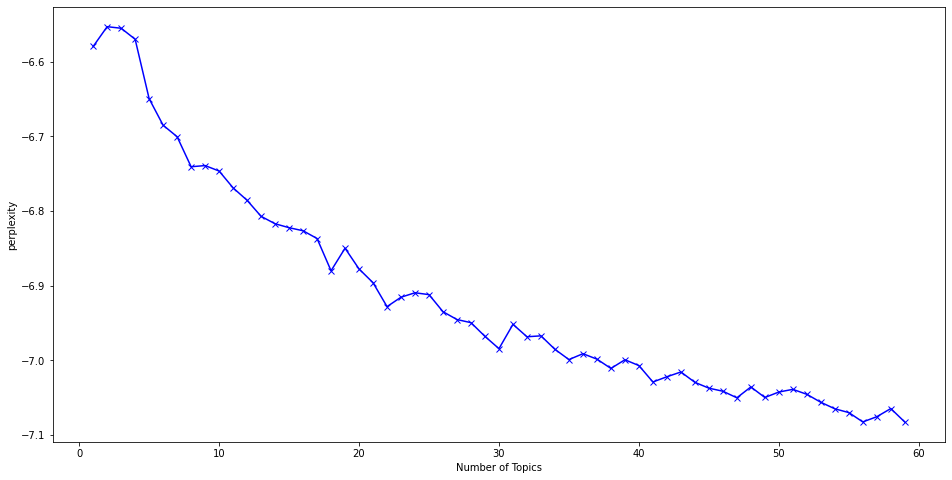

In [28]:
from gensim.models import LdaModel
import matplotlib.pyplot as plt
d=[]
n=range(1,60)
for i in n:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i)
    perplexity = model.log_perplexity(corpus)
    d.append(perplexity)
plt.figure(figsize=(16,8))
plt.plot(n, d, 'bx-')
plt.xlabel('Number of Topics')
plt.ylabel('perplexity')
plt.show()

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models

num_topics=35

pyLDAvis.enable_notebook()
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21    -0.272624 -0.126983       1        1  5.442430
31    -0.093828 -0.015238       2        1  4.876116
18    -0.126271  0.182325       3        1  4.695122
34     0.016846 -0.108574       4        1  4.298046
23     0.041923  0.005898       5        1  3.732258
33    -0.158598 -0.115823       6        1  3.590543
8      0.170815 -0.041281       7        1  3.412959
22     0.113654  0.039069       8        1  3.228747
2      0.142443 -0.012903       9        1  3.085173
12    -0.078722 -0.040331      10        1  3.010901
10    -0.094024 -0.082035      11        1  2.890902
26     0.001173 -0.074065      12        1  2.833301
28    -0.000691 -0.081372      13        1  2.803303
0      0.039101  0.159863      14        1  2.798446
5     -0.032876 -0.012098      15        1  2.714684
3     -0.148570  0.296267      16        1  2.696669
24    -0.006706 -0.042801      17        1  2.664429
1      0.084854 -0.004581      18        1  2.587268
25     0.073262  0.034183      19        1  2.526378
16     0.151239 -0.004450      20        1  2.456608
17     0.023358  0.002214      21        1  2.443160
6     -0.105781 -0.001740      22        1  2.440588
11    -0.018526  0.246729      23        1  2.393725
32     0.065345 -0.008173      24        1  2.385308
4      0.128588 -0.041441      25        1  2.370619
19     0.039598  0.059517      26        1  2.361595
13    -0.138757 -0.046125      27        1  2.333527
7     -0.046951 -0.051490      28        1  2.309849
20     0.052900 -0.050519      29        1  2.299042
30     0.111792  0.007451      30        1  2.236063
29     0.021884  0.004993      31        1  2.187641
14     0.028246  0.001051      32        1  2.054080
27     0.022557 -0.021399      33        1  2.032464
15     0.038331 -0.022835      34        1  2.024580
9     -0.044989 -0.033304      35        1  1.783477, topic_info=          Term          Freq         Total Category  logprob  loglift
14         ata  22598.000000  22598.000000  Default  30.0000  30.0000
75      column  18712.000000  18712.000000  Default  29.0000  29.0000
511      error  11042.000000  11042.000000  Default  28.0000  28.0000
9     function  14335.000000  14335.000000  Default  27.0000  27.0000
67        list   8418.000000   8418.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2346     unuse    213.925204    214.875242  Topic35  -4.5198   4.0222
2085      rate    206.219748    207.169792  Topic35  -4.5564   4.0220
120     region    200.491994    201.442268  Topic35  -4.5846   4.0219
11           r    952.027264  82592.136397  Topic35  -3.0268  -0.4365
211     number    412.541823   4481.295138  Topic35  -3.8630   1.6413

[1315 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1399     21  0.998891    0
693      10  0.999704    1
2350     23  0.997009   10
29       22  0.992868  100
445      10  0.999381    2
...     ...       ...  ...
559      11  0.991349  zip
2382     30  0.997611    ‘
2383     30  0.995171    ’
2166     30  0.994543    “
2460     30  0.994364    ”

[1445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 32, 19, 35, 24, 34, 9, 23, 3, 13, 11, 27, 29, 1, 6, 4, 25, 2, 26, 17, 18, 7, 12, 33, 5, 20, 14, 8, 21, 31, 30, 15, 28, 16, 10])

In [33]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -9.2555.
[([(0.12165864, 'loop'),
   (0.10197141, 'create'),
   (0.10025963, 'name'),
   (0.08865783, 'r'),
   (0.05808821, 'column'),
   (0.053191673, 'specific'),
   (0.04655573, 'variable'),
   (0.038900804, 'apply'),
   (0.038672555, 'new'),
   (0.036481004, 'function'),
   (0.03604944, 'using'),
   (0.018913059, 'cell'),
   (0.017786065, 'long'),
   (0.015183559, 'multiple'),
   (0.013913311, 'efine'),
   (0.013428695, 'create_new'),
   (0.011406847, 'use'),
   (0.011189817, 'tree'),
   (0.01077164, 'part'),
   (0.010450091, 'elete')],
  -4.8375071609201985),
 ([(0.16250402, 'plot'),
   (0.07668554, 'ggplot2'),
   (0.07443605, 'multiple'),
   (0.055969976, 'r'),
   (0.04527954, 'color'),
   (0.040198527, 'bar'),
   (0.038600378, 'return'),
   (0.03403856, 'ggplot'),
   (0.033633552, 'using'),
   (0.025302023, 'test'),
   (0.025103753, 'chart'),
   (0.018765267, 'isplay'),
   (0.01869974, 'variable'),
   (0.017758818, 'scale'),
   (0.017078938, 'histogram')

## **Findings**
### The objective of this task is classify and find topics that the people care about on stackoverflow website.
### I extracted the best topics number by using curve and used pyLDAvis to see the behavior of our model depending on the selected number of topics.
### We have 35 topics each one contains number of categories, the most repeated ones are (plot, ggplot, row, value, r, error, list).
### Which means, our researchers care and search about (plot, ggplot, r, row, value, error, list) mostly on stackoverflow.
### Most of overlapped topics contain categories like 'r' and it makes sense because the data about 'r', so it makes no problem.